TD(0) Advantage Actor Critic(A2C) Cartpole-v1 environment

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import time

In [2]:
class A2C(nn.Module):
    def __init__(self):
        super(A2C, self).__init__()
        self.loss_list = []
        self.fc1 = nn.Linear(4,256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.003)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        policy = F.softmax(self.fc_pi(x), dim=0)
        v = self.fc_v(x)
        return policy, v
    
    def gather_loss(self, loss):
        self.loss_list.append(loss.unsqueeze(0))
        
    def train(self):
        loss = torch.cat(self.loss_list).sum()
        loss /= len(self.loss_list)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.loss_list = []

In [3]:
env = gym.make('CartPole-v1')
model = A2C()
model.cuda()
GAMMA = 0.99

In [4]:
reward_sum = 0.0
reward_list = []

for ep in range(1500):
    observation = env.reset()
    while True:
        state = torch.tensor(observation, dtype=torch.float).cuda()
        policy, value = model(state)
        action = Categorical(policy).sample()
        
        observation, reward, done, _ = env.step(action.item())
        reward_sum += reward
        next_state = torch.tensor(observation, dtype=torch.float).cuda()
        _, next_value = model(next_state)
        td_error = reward + GAMMA*next_value - value
        loss = -torch.log(policy[action.detach()])*td_error.detach() + (td_error)**2
        model.gather_loss(loss)
        if done:
            break
    model.train()
    
    if ep % 100 == 99:
        print('Episode %d'%ep,', Reward mean : %f'%(reward_sum/100.0))
        reward_list.append(reward_sum/100.0)
        #plt.plot(reward_list)
        #plt.show()
        reward_sum = 0.0
env.close()

Episode 99 , Reward mean : 32.850000
Episode 199 , Reward mean : 56.430000
Episode 299 , Reward mean : 100.540000
Episode 399 , Reward mean : 86.900000
Episode 499 , Reward mean : 161.950000
Episode 599 , Reward mean : 251.430000
Episode 699 , Reward mean : 314.710000
Episode 799 , Reward mean : 382.000000
Episode 899 , Reward mean : 457.240000
Episode 999 , Reward mean : 464.520000
Episode 1099 , Reward mean : 498.410000
Episode 1199 , Reward mean : 491.530000
Episode 1299 , Reward mean : 492.040000
Episode 1399 , Reward mean : 499.620000
Episode 1499 , Reward mean : 499.470000


Learning curve

mean reward every 100 episodes

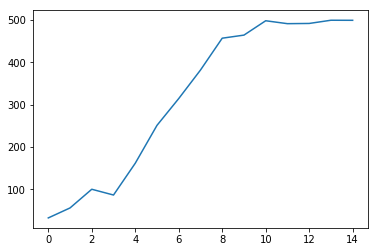

In [5]:
plt.plot(reward_list)
plt.show()

Test Rendering

In [7]:
for ep in range(10):
    observation = env.reset()
    while True:
        time.sleep(0.05)
        env.render()

        state = torch.tensor(observation, dtype=torch.float).cuda()
        policy, value = model(state)
        action = Categorical(policy).sample()
        observation, reward, done, _ = env.step(action.item())
        if done: break
env.close()

- Reference

https://github.com/seungeunrho/minimalRL